Part 2: Depth from Rectified Stereo Images

Write a program to estimate a depth map from the pair of rectified images in Figure 2 using an MRF and multiple label graphcuts.
Show your best result and provide some discussion if necessary (particularly if the results are not as good as expected).

In [1]:

import numpy
import statistics
import cv2
from functools import cache
from gco import pygco
from utils import get_logger, INTEGER_MAX_VALUE
import matplotlib.image
import matplotlib.pyplot
import queue
import typing
import gc

/Users/admin/EE5371/CA2/.venv/lib/python3.10/site-packages/gco/__init__.py:7: FutureWarning: In the future `np.bool` will be defined as the corresponding NumPy scalar.
  if not hasattr(numpy, name):


In [2]:
# @cache
def compute_distance(point1: numpy.ndarray, point2: numpy.ndarray) -> float:
    """
    compute distance of two pixels
    Parameters
    ----------
    point1: ndarray, uint8, shape=(3)
        point one
    point2: ndarray, uint8, shape=(3)
        point two
    """
    # return (abs(point1[0]-point2[0]) + abs(point1[1] - point2[1]) + abs(point1[2] - point2[2]) ) / 3 / 255
    # if not dividing 255 as the C pseudocode example, there will be a overflowing of MAX_VALUE of Integer when calling pycgo.cut_grid_graph
    return numpy.sum(numpy.abs(point1-point2)) /3
def linear_normalize(data: numpy.ndarray) -> numpy.ndarray:
    """
        linear normalize
    """
    min_value = data.min()
    max_value = data.max()
    normalized_data = (data - min_value) / (max_value - min_value)
    return normalized_data

def normal_distribution_normalize(data: numpy.ndarray) -> numpy.ndarray:
    """
        normalize by normal distribution
    """
    mean = numpy.mean(data)
    std = numpy.std(data)
    normalized_data = (data - mean) / std
    return normalized_data


In [3]:
img1: numpy.ndarray = cv2.imread("data/rectified_image_1.png", cv2.IMREAD_COLOR)
img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
height1, width1, _ = img1.shape

img2: numpy.ndarray = cv2.imread("data/rectified_image_2.png", cv2.IMREAD_COLOR)
img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)
img2 = cv2.resize(img2, (width1, height1))

height2, width2, _ = img2.shape
row_list: [INTEGER_MAX_VALUE] * width2
disparity_by_y: typing.List[int] = []
disparity_by_x: typing.List[int] = []
for y in range(height1):
    # img2: still y
    disparity_by_x.clear()
    for x1 in range(width1):
        pq = queue.PriorityQueue()
        for x2 in range(width2):
            pixel1 = img1[y, x1]
            pixel2 = img2[y, x2]
            dis = compute_distance(point1=pixel1, point2=pixel2)
            pq.put(item=(dis, x2))
        x2_argmin = pq.get()[1]
        disparity = abs(x2_argmin - x1)
        disparity_by_x.append(disparity)
    mode = statistics.mode(disparity_by_x)
    disparity_by_y.append(mode)
disparity_by_x.clear()

disparity_by_y:[20, 19, 19, 18, 21, 20, 20, 19, 20, 17, 18, 18, 21, 18, 19, 20, 21, 20, 20, 20, 18, 19, 20, 18, 15, 20, 19, 20, 18, 24, 20, 20, 18, 19, 16, 20, 18, 20, 19, 19, 20, 20, 21, 20, 20, 19, 21, 18, 20, 21, 18, 22, 23, 23, 23, 21, 23, 21, 19, 20, 21, 22, 22, 20, 22, 22, 22, 21, 20, 19, 20, 19, 19, 19, 19, 22, 21, 19, 21, 21, 20, 20, 20, 22, 20, 22, 19, 21, 20, 22, 23, 18, 24, 19, 18, 22, 19, 20, 25, 25, 20, 23, 22, 18, 27, 18, 19, 20, 20, 19, 25, 23, 20, 22, 19, 26, 26, 25, 25, 20, 25, 19, 20, 20, 20, 23, 20, 24, 25, 18, 18, 29, 32, 31, 25, 30, 32, 30, 28, 32, 31, 21, 30, 39, 29, 29, 29, 27, 31, 23, 31, 27, 27, 29, 32, 27, 27, 31, 26, 30, 31, 30, 33, 32, 32, 29, 30, 32, 28, 28, 31, 30, 32, 30, 30, 28, 31, 30, 30, 30, 32, 33, 32, 29, 31, 30, 33, 29, 30, 30, 30, 35, 32, 30, 30, 30, 28, 27, 33, 32, 29, 32, 43, 40, 33, 33, 29, 32, 42, 38, 30, 34, 28, 30, 25, 32, 33, 36, 30, 30, 31, 33, 32, 29, 44, 34, 49, 37, 31, 28, 37, 34, 34, 37, 46, 43, 36, 39, 39, 40, 40, 38, 42, 39, 38, 36, 

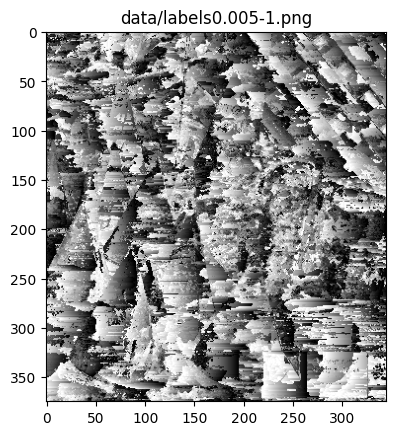

fp:[[ 0  1  2 ... 42 43 44]
 [ 1  0  1 ... 41 42 43]
 [ 2  1  0 ... 40 41 42]
 ...
 [42 41 40 ...  0  1  2]
 [43 42 41 ...  1  0  1]
 [44 43 42 ...  2  1  0]]
labels:[[34 35 34 ... 43 42 44]
 [27 34 34 ... 44 43 42]
 [27 31 33 ...  0 44 43]
 ...
 [42 43 40 ... 28 41 32]
 [43 42 43 ... 30 29 22]
 [37 41 43 ... 30 26 12]]


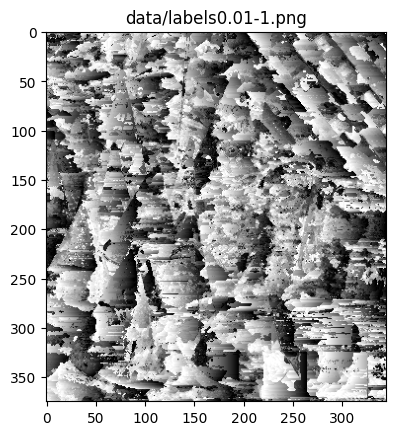

fp:[[ 0  1  2 ... 42 43 44]
 [ 1  0  1 ... 41 42 43]
 [ 2  1  0 ... 40 41 42]
 ...
 [42 41 40 ...  0  1  2]
 [43 42 41 ...  1  0  1]
 [44 43 42 ...  2  1  0]]
labels:[[34 35 34 ... 43 42 44]
 [27 34 34 ... 44 43 42]
 [27 31 33 ...  0 44 43]
 ...
 [43 43 43 ... 29 33 32]
 [43 43 43 ... 30 29 26]
 [43 43 43 ... 30 27 26]]


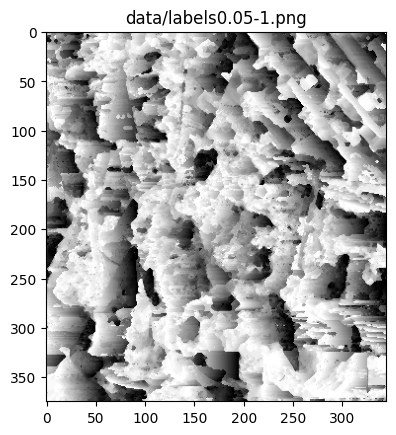

fp:[[ 0  1  2 ... 42 43 44]
 [ 1  0  1 ... 41 42 43]
 [ 2  1  0 ... 40 41 42]
 ...
 [42 41 40 ...  0  1  2]
 [43 42 41 ...  1  0  1]
 [44 43 42 ...  2  1  0]]
labels:[[15 25 24 ... 43 42 44]
 [16 22 25 ... 44 43 42]
 [17 15 18 ...  0 44 43]
 ...
 [43 43 43 ... 32 33 32]
 [43 43 43 ... 30 30 26]
 [43 43 43 ... 30 27 26]]


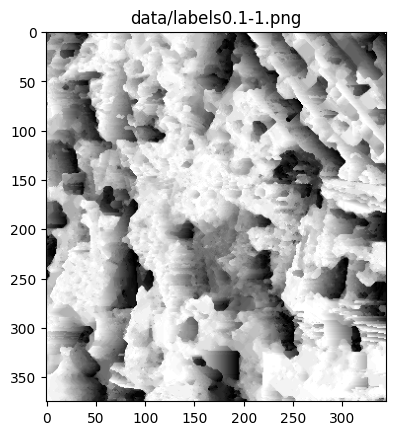

fp:[[ 0  1  2 ... 42 43 44]
 [ 1  0  1 ... 41 42 43]
 [ 2  1  0 ... 40 41 42]
 ...
 [42 41 40 ...  0  1  2]
 [43 42 41 ...  1  0  1]
 [44 43 42 ...  2  1  0]]
labels:[[14 12 11 ...  0  0  0]
 [10 14 13 ...  1  0  0]
 [ 9 15 16 ...  0  0  0]
 ...
 [43 43 43 ... 33 33 32]
 [43 43 43 ... 31 31 26]
 [43 43 43 ... 30 29 28]]


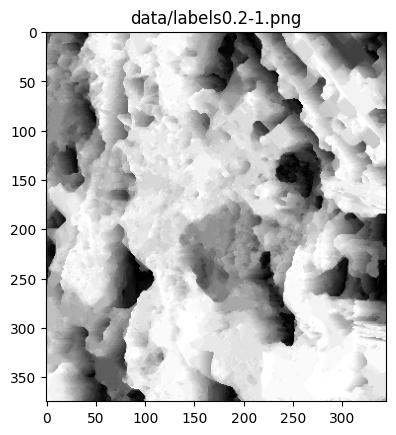

fp:[[ 0  1  2 ... 42 43 44]
 [ 1  0  1 ... 41 42 43]
 [ 2  1  0 ... 40 41 42]
 ...
 [42 41 40 ...  0  1  2]
 [43 42 41 ...  1  0  1]
 [44 43 42 ...  2  1  0]]
labels:[[10 10 11 ...  0  0  0]
 [10 10 12 ...  0  0  0]
 [ 9 15 16 ...  0  0  0]
 ...
 [43 43 43 ... 38 36 36]
 [43 43 43 ... 32 31 26]
 [43 43 43 ... 30 29 28]]


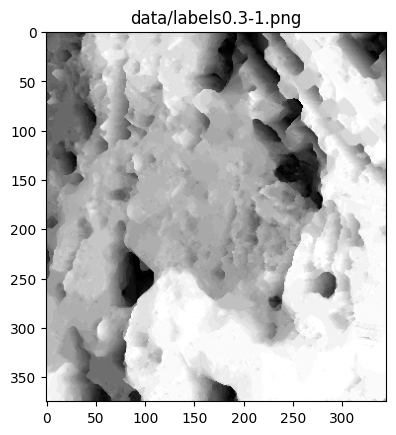

fp:[[ 0  1  2 ... 42 43 44]
 [ 1  0  1 ... 41 42 43]
 [ 2  1  0 ... 40 41 42]
 ...
 [42 41 40 ...  0  1  2]
 [43 42 41 ...  1  0  1]
 [44 43 42 ...  2  1  0]]


In [ ]:
print(f"disparity_by_y:{disparity_by_y}")
tem = img1
img1 = img2
img2 = tem
depth_min = min(disparity_by_y)
depth_max = max(disparity_by_y)
depth_range = depth_max - depth_min
print(f"depth_range:{depth_range}")
# todo: change to list
STEP = 1
unary_cost: numpy.ndarray = numpy.zeros(shape=(height1, width1, depth_range), dtype=numpy.float64)
for y in range(height1):
    for x in range(width1):
        x2_start = min(width1 - 1, x + depth_min)
        x2_end = min(width1, x2_start + STEP)
        for i in range(depth_range):
            img2_matched = img2[y, x2_start: x2_end]
            x2_start = min(width1 - 1, x2_start + STEP)
            x2_end = min(width1, x2_start + STEP)
            disparity_by_x.clear()
            for pixel2 in img2_matched:
                disparity_by_x.append(compute_distance(point1=img1[y,x], point2=pixel2))
            unary_cost[y, x, i] = min(disparity_by_x) /3 / 255
# unary_cost = linear_normalize(data=unary_cost)
unary_cost *= depth_range
# print(f"unary_cost:{unary_cost}")
unary_cost = unary_cost[:, : width1-depth_max, :]
i = numpy.arange(depth_range, dtype=numpy.int32)
j = numpy.arange(depth_range, dtype=numpy.int32)
fp = numpy.abs(i[: , numpy.newaxis] - j)
LAMBDAS = [0.005,0.006, 0.007, 0.008, 0.009 0.01,0.05,0.1, 0.2, 0.3,0.4]
for lam in LAMBDAS:
    gc.collect()
    print(f"fp:{fp}")
    labels = pygco.cut_grid_graph_simple(unary_cost=unary_cost, pairwise_cost=fp * lam, connect=8, algorithm='swap')
    labels = labels.reshape(unary_cost.shape[0], unary_cost.shape[1])
    labels = labels[:,depth_range:]
    print(f"labels:{labels}")
    img_path = f"data/labels{lam}-{STEP}.png"
    cv2.imwrite(img_path, labels)
    img_show = matplotlib.image.imread(img_path)
    matplotlib.pyplot.title(img_path)
    matplotlib.pyplot.imshow(X=img_show, cmap='gray') 
    matplotlib.pyplot.show()